In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEED = 515
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Network defination and backprop

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input channel, 6 output channel, 5*5 convolution kernel
        # `kernel_size` could be a tuple, or integer if it is a square
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # 6 input channel, 16 output channel, 5*5 convolution kernel
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Affine operation: y = xW + b
        # `fc` stands for "full connection". 
        # 16*5*5 input, 120 output
        # ((32-4)/2-4)/2 = 5, so it is image of 5*5 size after last pooling layer
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # x: (batch, channel, height, width)
        x = F.relu(self.conv1(x))
        # Max pooling over 2*2 window
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        # x: (batch, channel, height, width) -> (batch, features)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# Instance the network
net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [4]:
# Learnable parameters
params = list(net.parameters())
print(len(params))

for param in params:
    print(param.size())

10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [5]:
# Forward propagation
in1 = torch.randn(1, 1, 32, 32)
# DO NOT use net.forward(in1)??
out1 = net(in1)
print(out1)

tensor([[-0.0528,  0.1306,  0.0023,  0.0178,  0.0009,  0.0774,  0.0978,  0.1136,
          0.0105, -0.1209]], grad_fn=<AddmmBackward>)


In [6]:
# Calculate the loss
target1 = torch.arange(0, 10, dtype=torch.float)
target1 = target1.view(1, -1)  # make it the same shape as output
print(target1)

criterion = nn.MSELoss()
loss = criterion(out1, target1)
print(loss)
print(((out1-target1)**2).mean())

tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])
tensor(28.3150, grad_fn=<MseLossBackward>)
tensor(28.3150, grad_fn=<MeanBackward0>)


In [7]:
# Forward propagation in minibatch 
# Input-shape: (minibatch size, channel size, fig height, fig width)
in2 = torch.randn(4, 1, 32, 32)
out2 = net(in2)
print(out2)

tensor([[-0.0748,  0.1370,  0.0183,  0.0339,  0.0045,  0.0758,  0.1119,  0.1128,
          0.0014, -0.1048],
        [-0.0663,  0.1442,  0.0243,  0.0220, -0.0126,  0.0765,  0.1006,  0.0988,
          0.0168, -0.1192],
        [-0.0694,  0.1366,  0.0144,  0.0245, -0.0010,  0.0803,  0.1015,  0.1120,
         -0.0065, -0.1085],
        [-0.0637,  0.1548,  0.0035,  0.0008,  0.0088,  0.0575,  0.0946,  0.0868,
          0.0088, -0.1052]], grad_fn=<AddmmBackward>)


In [8]:
# Calculate the loss
target2 = torch.arange(0, 40, dtype=torch.float).view(4, -1)
print(target2)

criterion = nn.MSELoss()
loss = criterion(out2, target2)
print(loss)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
        [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
        [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.]])
tensor(512.5129, grad_fn=<MseLossBackward>)


In [9]:
# Show the loss functions...
# MSELoss
print(loss.grad_fn)
# Linear
print(loss.grad_fn.next_functions[0][0])
# ReLU
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

In [10]:
# Backward propagation 
# Zeros the gradient buffers of all parameters
net.zero_grad()
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0232, -0.2331, -0.2596,  0.4052, -0.2512, -0.3117])


In [11]:
# Update weights
# SGD implemented by Python
learning_rate = 0.01
for param in net.parameters():
    param.data.sub_(param.grad.data * learning_rate)

In [12]:
# torch implemetation
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer.step()

# Example: LeNet 

In [13]:
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 200, kernel_size=5)
        self.conv2 = nn.Conv2d(200, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
# Instance the network
net = Net()
net

Net(
  (conv1): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(200, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device:', device)
net.to(device)
net

device: cuda


Net(
  (conv1): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(200, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
t0 = time.time()
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ins, labels = data
        ins, labels = ins.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outs = net(ins)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if (i+1) % 200 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/200))
            running_loss = 0.0

t1 = time.time()
print('Training time: %f' % (t1-t0))

[1,   200] loss: 2.299
[1,   400] loss: 2.257
[1,   600] loss: 2.090
[2,   200] loss: 1.848
[2,   400] loss: 1.764
[2,   600] loss: 1.698
[3,   200] loss: 1.581
[3,   400] loss: 1.544
[3,   600] loss: 1.506
[4,   200] loss: 1.444
[4,   400] loss: 1.409
[4,   600] loss: 1.397
[5,   200] loss: 1.347
[5,   400] loss: 1.346
[5,   600] loss: 1.309
Training time: 90.774746


bird


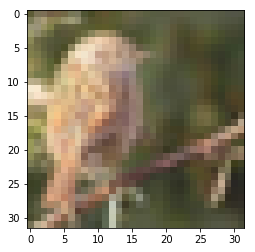

In [20]:
# Get some random training images and show
dataiter = iter(trainloader)
images, labels = dataiter.next()

i = 0
print(classes[labels[i]])
img = images[0].numpy() # unnormalize to 0~1
img = np.transpose(img / 2 + 0.5, (1, 2, 0))
plt.imshow(img)

In [21]:
print('GroundTruth: ')
print([classes[labels[i]] for i in range(10)])

outs = net(images.to(device))
_, predicted = torch.max(outs, 1)
print('Predicted: ')
print([classes[predicted[i]] for i in range(10)])

GroundTruth: 
['bird', 'bird', 'frog', 'truck', 'ship', 'dog', 'bird', 'deer', 'deer', 'dog']
Predicted: 
['frog', 'frog', 'cat', 'car', 'ship', 'dog', 'plane', 'deer', 'deer', 'cat']
